# MP1 : Antoine Salmona

On peut tout d'abord faire quelque import utile pour tout le projet:

In [31]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from keras import optimizers
from keras.utils import to_categorical
import matplotlib.pyplot as plt
    

Ensuite, on peut copier coller le code fourni:

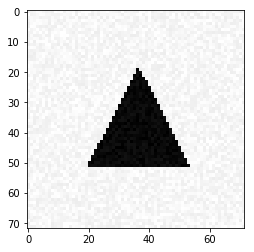

In [19]:
import matplotlib.pyplot as plt

import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i, end =' ')
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i, end= ' ')
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]




## 3/

On genere le dataset:

In [36]:
[X_train, Y_train] = generate_dataset_classification(300, 20)
Y_train = to_categorical(Y_train)

Creating data:
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 

Comme on a un problème de multi-classification, on choisi une loss de type 'categorical crossentropy' et une fonction d'activation softmax. Comme il y a 3 classes, on met 3 neurones.

In [37]:
model = Sequential()
model.add(Dense(3, activation = 'softmax'))


On essaye d'abord d'optimiser avec un stochastic gradient descent (résultats pas super) puis avec adam:

In [38]:
sgd = optimizers.SGD()
#model.compile(loss = 'categorical_crossentropy', optimizer = sgd)

adam = optimizers.Adam()
model.compile(loss = 'categorical_crossentropy', optimizer = adam)


On peut alors lancer le training:

In [39]:
history = model.fit(X_train, Y_train, epochs=100) 

Epoch 1/100
300/300 [==============================] - 0s 646us/step - loss: 2.4442
Epoch 2/100
300/300 [==============================] - 0s 109us/step - loss: 1.4736
Epoch 3/100
300/300 [==============================] - 0s 141us/step - loss: 0.6807
Epoch 4/100
300/300 [==============================] - 0s 136us/step - loss: 0.4708
Epoch 5/100
300/300 [==============================] - 0s 150us/step - loss: 0.3670
Epoch 6/100
300/300 [==============================] - 0s 122us/step - loss: 0.3307
Epoch 7/100
300/300 [==============================] - 0s 139us/step - loss: 0.2748
Epoch 8/100
300/300 [==============================] - 0s 157us/step - loss: 0.2705
Epoch 9/100
300/300 [==============================] - 0s 145us/step - loss: 0.2349
Epoch 10/100
300/300 [==============================] - 0s 126us/step - loss: 0.2262
Epoch 11/100
300/300 [==============================] - 0s 124us/step - loss: 0.2360
Epoch 12/100
300/300 [==============================] - 0s 119us/step - lo

300/300 [==============================] - 0s 136us/step - loss: 0.0092
Epoch 98/100
300/300 [==============================] - 0s 121us/step - loss: 0.0093
Epoch 99/100
300/300 [==============================] - 0s 142us/step - loss: 0.0090
Epoch 100/100
300/300 [==============================] - 0s 122us/step - loss: 0.0092


On peut alors plot la loss en fonction du nombre d'epoch:

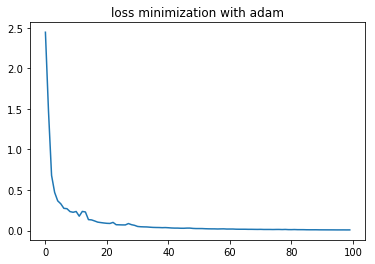

In [44]:
plt.plot(history.history['loss'])
plt.title('loss minimization with adam')
plt.show()

On peu alors verifier nos resultats:

In [35]:
X_test = mp1.generate_a_rectangle() 
X_test = X_test.reshape(1, X_test.shape[0]) 
model.predict(X_test)

array([[1., 0., 0.]], dtype=float32)

In [41]:
X_test = mp1.generate_a_disk() 
X_test = X_test.reshape(1, X_test.shape[0]) 
model.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

In [43]:
X_test = mp1.generate_a_triangle()[0]
X_test = X_test.reshape(1, X_test.shape[0]) 
model.predict(X_test)

array([[0., 0., 1.]], dtype=float32)

Cela a l'air de marcher plutot bien...

## 4/

On calcule les poids en utilsant get_weights():

In [46]:
weights = model.get_weights()

Ensuite on peut les plots:

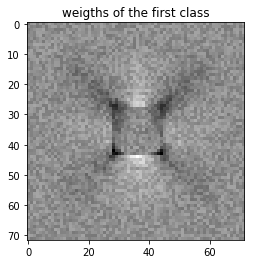

In [49]:
IMAGE_SIZE = 72
plt.imshow(weights[0][:,0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title("weigths of the first class")
plt.show()

On reconnait bien un rectangle

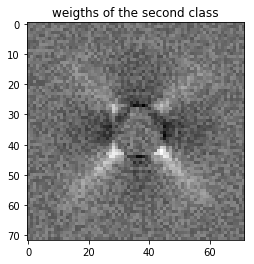

In [51]:
IMAGE_SIZE = 72
plt.imshow(weights[0][:,1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title("weigths of the second class")
plt.show()

On reconnait un cercle (pas super)

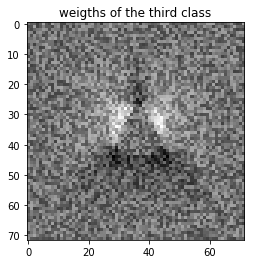

In [52]:
IMAGE_SIZE = 72
plt.imshow(weights[0][:,2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title("weigths of the third class")
plt.show()

On devine bien un triangle

## 5/

On peut génerer le dataset:

In [60]:
[X_train, Y_train] = generate_dataset_classification(1000, 20, True)
Y_train = to_categorical(Y_train)

Creating data:
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 

puis redéfinir le model:

In [72]:
model2 = Sequential()
model2.add(Dense(3, activation = 'softmax'))
adam = optimizers.Adam(lr=5e-5)
model2.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics=['accuracy'])

puis lancer le training:

In [73]:
history = model2.fit(X_train, Y_train, epochs=100) 

Epoch 1/100
1000/1000 [==============================] - 1s 1ms/step - loss: 1.2233 - acc: 0.3230
Epoch 2/100
1000/1000 [==============================] - 0s 120us/step - loss: 1.1008 - acc: 0.3640
Epoch 3/100
1000/1000 [==============================] - 0s 131us/step - loss: 1.0804 - acc: 0.3900
Epoch 4/100
1000/1000 [==============================] - 0s 126us/step - loss: 1.0619 - acc: 0.4250
Epoch 5/100
1000/1000 [==============================] - 0s 119us/step - loss: 1.0315 - acc: 0.4760
Epoch 6/100
1000/1000 [==============================] - 0s 126us/step - loss: 1.0156 - acc: 0.4920
Epoch 7/100
1000/1000 [==============================] - 0s 115us/step - loss: 0.9987 - acc: 0.4890
Epoch 8/100
1000/1000 [==============================] - 0s 138us/step - loss: 0.9886 - acc: 0.5060
Epoch 9/100
1000/1000 [==============================] - 0s 116us/step - loss: 0.9708 - acc: 0.5200
Epoch 10/100
1000/1000 [==============================] - 0s 134us/step - loss: 0.9587 - acc: 0.5350
E

1000/1000 [==============================] - 0s 104us/step - loss: 0.7625 - acc: 0.6400
Epoch 83/100
1000/1000 [==============================] - 0s 97us/step - loss: 0.7655 - acc: 0.6210
Epoch 84/100
1000/1000 [==============================] - 0s 104us/step - loss: 0.7574 - acc: 0.6450
Epoch 85/100
1000/1000 [==============================] - 0s 119us/step - loss: 0.7706 - acc: 0.6260
Epoch 86/100
1000/1000 [==============================] - 0s 98us/step - loss: 0.7578 - acc: 0.6460
Epoch 87/100
1000/1000 [==============================] - 0s 114us/step - loss: 0.7615 - acc: 0.6420
Epoch 88/100
1000/1000 [==============================] - 0s 116us/step - loss: 0.7855 - acc: 0.5920
Epoch 89/100
1000/1000 [==============================] - 0s 103us/step - loss: 0.7611 - acc: 0.6430
Epoch 90/100
1000/1000 [==============================] - 0s 96us/step - loss: 0.7583 - acc: 0.6580
Epoch 91/100
1000/1000 [==============================] - 0s 105us/step - loss: 0.7551 - acc: 0.6390
Epoch 

puis plot la loss: 

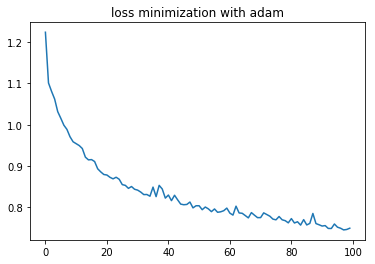

In [74]:
plt.plot(history.history['loss'])
plt.title('loss minimization with adam')
plt.show()

On a seulement 64% d'accuracy sur le training set, ce qui n'est pas satisfaisant, on peut quand meme tester sur un nouveau dataset:

In [79]:
[X_test, Y_test] = generate_test_set_classification()
Y_test = to_categorical(Y_test, 3)

Creating data:
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 

puis évaluer:

In [81]:
model.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 443us/step


[1.2526180680592855, 0.6166666658719381]

On a une accuracy de 61%, ainsi meme si le reseau n'est pas très bon, il a une bonne capacité à généraliser.

On peut alors essayer avec un CNN (en utilisant l'architecture suggéré):

In [96]:
model3 = Sequential()
model3.add(Conv2D(16,(5,5), activation='relu', input_shape = (72,72,1)))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Flatten())
model3.add(Dense(3, activation='softmax')) 


In [97]:
adam = optimizers.Adam()
model3.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics=['accuracy'])

On reshape alors X_train pour le training:

In [94]:
[X_train, Y_train] = generate_dataset_classification(1000, 20, True)
Y_train = to_categorical(Y_train)
X_train = X_train.reshape(X_train.shape[0],72,72,1)

Creating data:
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 

puis on lance le training:

In [98]:
history = model3.fit(X_train, Y_train, epochs=100) 

Epoch 1/100
1000/1000 [==============================] - 3s 3ms/step - loss: 1.0900 - acc: 0.4830
Epoch 2/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.7656 - acc: 0.6780
Epoch 3/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6421 - acc: 0.7710
Epoch 4/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5709 - acc: 0.7850
Epoch 5/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5172 - acc: 0.8200
Epoch 6/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.4680 - acc: 0.8470
Epoch 7/100
1000/1000 [==============================] - 4s 4ms/step - loss: 0.4200 - acc: 0.8690
Epoch 8/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.4096 - acc: 0.8610
Epoch 9/100
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3650 - acc: 0.8800
Epoch 10/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3494 - acc: 0.8890
Epoch 11/100
1000/1

1000/1000 [==============================] - 3s 3ms/step - loss: 0.0043 - acc: 1.0000
Epoch 84/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0042 - acc: 1.0000
Epoch 85/100
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0041 - acc: 1.0000
Epoch 86/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0041 - acc: 1.0000
Epoch 87/100
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0038 - acc: 1.0000
Epoch 88/100
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0038 - acc: 1.0000
Epoch 89/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0036 - acc: 1.0000
Epoch 90/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0037 - acc: 1.0000
Epoch 91/100
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0034 - acc: 1.0000
Epoch 92/100
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0033 - acc: 1.0000
Epoch 93/100
1000/1000 

On a alors une accuracy de 100%, ce qui est bien mieux, on peut alors plot la loss:

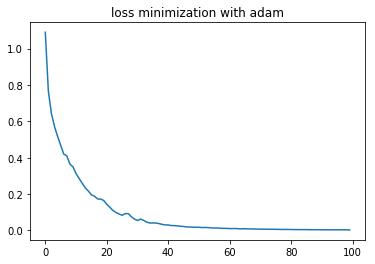

In [99]:
plt.plot(history.history['loss'])
plt.title('loss minimization with adam')
plt.show()

On peut alors tester sur un nouveau dataset:

In [102]:
[X_test, Y_test] = generate_test_set_classification()
Y_test = to_categorical(Y_test, 3)
X_test = X_test.reshape(X_test.shape[0],72,72,1)
model3.evaluate(X_test, Y_test)

Creating data:
300/300 [==============================] - 1s 2ms/step60 170 180 190 200 210 220 230 240 250 260 


[0.36658350586891175, 0.8833333325386047]

On a une accuracy de 88% sur le test_set, ce qui est satisfaisant. Le reseaux a donc un bonne capacité a géneraliser.

## 6/

On génère le dataset:

In [105]:
[X_train, Y_train] = generate_dataset_regression(1000, 20)


Creating data:
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 

On normalise Y en triant les sommet de gauche à droite:

In [106]:
def normalize(Y_train):
    Y_train_norm = []
    for y in Y_train:
        y = y.reshape((3,2))
        y = sorted(y,key=lambda y: y.T[0])
        y = np.ravel(y)
        Y_train_norm.append(y)
    Y_train_norm = np.array(Y_train_norm)
    return Y_train_norm

    

In [107]:
X_train = X_train.reshape(X_train.shape[0],72,72,1)
Y_train = normalize(Y_train)


Ensuite on peut définir l'architecture, J'ai choisi d'alterner des couches de convolution et de max_pooling. Puis je termine par des couches denses (la dernière a 6 neurones car y est de taille 6)

In [111]:
model4 = Sequential()
model4.add(Conv2D(16,(5,5), activation='relu', input_shape = (72,72,1)))
model4.add(MaxPooling2D(pool_size=(2,2)))
model4.add(Conv2D(32,(5,5), activation='relu', input_shape = (34,34,16)))
model4.add(MaxPooling2D(pool_size=(2,2)))
model4.add(Conv2D(64,(5,5), activation='relu', input_shape = (15,15,32)))
model4.add(MaxPooling2D(pool_size=(2,2)))
model4.add(Flatten())
model4.add(Dense(128, activation='relu' ))
model4.add(Dense(6, activation='relu')) 

On utilise une loss de type 'mean square error':

In [112]:
adam = optimizers.Adam(lr = 1e-4)
model4.compile(loss = 'mse', optimizer = adam)


On peut alors lancer le training:

In [114]:
history = model4.fit(X_train, Y_train, batch_size = 32, epochs=100) 

Epoch 1/100
1000/1000 [==============================] - 19s 19ms/step - loss: 0.1192
Epoch 2/100
1000/1000 [==============================] - 21s 21ms/step - loss: 0.0695
Epoch 3/100
1000/1000 [==============================] - 20s 20ms/step - loss: 0.0588
Epoch 4/100
1000/1000 [==============================] - 21s 21ms/step - loss: 0.0501
Epoch 5/100
1000/1000 [==============================] - 21s 21ms/step - loss: 0.0364
Epoch 6/100
1000/1000 [==============================] - 22s 22ms/step - loss: 0.0298
Epoch 7/100
1000/1000 [==============================] - 22s 22ms/step - loss: 0.0267
Epoch 8/100
1000/1000 [==============================] - 21s 21ms/step - loss: 0.0244
Epoch 9/100
1000/1000 [==============================] - 22s 22ms/step - loss: 0.0224
Epoch 10/100
1000/1000 [==============================] - 24s 24ms/step - loss: 0.0210
Epoch 11/100
1000/1000 [==============================] - 23s 23ms/step - loss: 0.0192
Epoch 12/100
1000/1000 [============================

1000/1000 [==============================] - 19s 19ms/step - loss: 0.0015
Epoch 96/100
1000/1000 [==============================] - 20s 20ms/step - loss: 0.0016
Epoch 97/100
1000/1000 [==============================] - 20s 20ms/step - loss: 0.0015
Epoch 98/100
1000/1000 [==============================] - 20s 20ms/step - loss: 0.0014
Epoch 99/100
1000/1000 [==============================] - 20s 20ms/step - loss: 0.0014
Epoch 100/100
1000/1000 [==============================] - 20s 20ms/step - loss: 0.0014


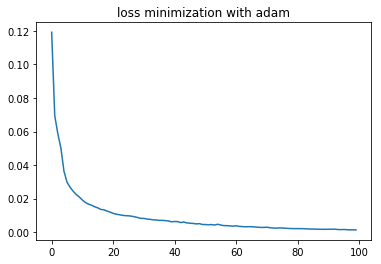

In [115]:
plt.plot(history.history['loss'])
plt.title('loss minimization with adam')
plt.show()

On peut alors tester sur un nouveau dataset:

In [116]:
[X_test, Y_test] = generate_test_set_regression()

Creating data:
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 

In [117]:
X_test = X_test.reshape(X_test.shape[0],72,72,1)
Y_test = normalize(Y_test)


In [118]:
result = model3.predict(X_test)

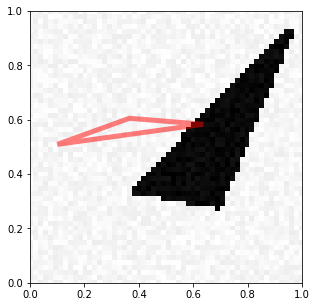

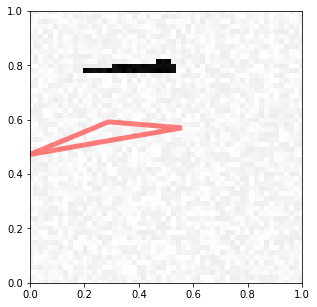

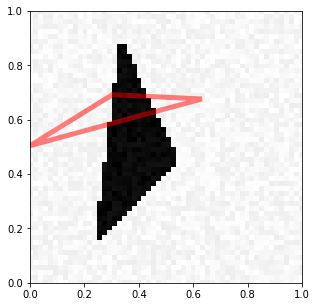

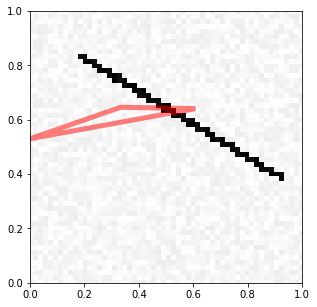

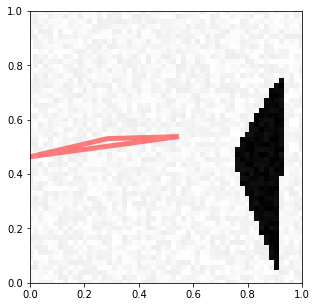

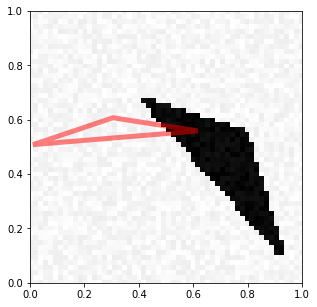

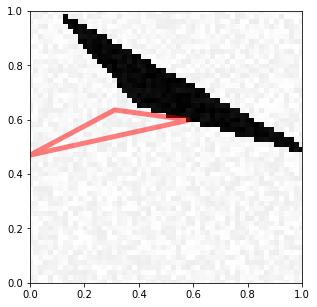

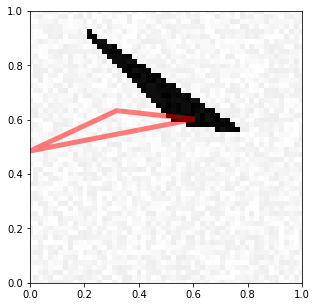

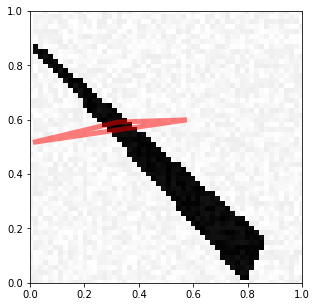

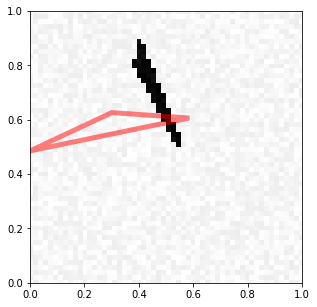

In [119]:
for k in range(10):
    mp1.visualize_prediction(X_test[k], result[k]) 

Ca ne marche pas du tout
